In [1]:
# hydro code
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import lambertw
from numba import jit
import upwind_scheme as uw
import copy
%matplotlib inline

In [2]:
### driver functions to build specific model

def full_boundary_update(bg,f,R0,h,cs,Sigma0):
    
    Sigma_boundary_update(bg,f,R0,Sigma0)
    velocity_boundary_update(bg,f,h,cs)
    
def Sigma_boundary_update(bg,f,R0,Sigma0):
    
    ### inner boundary
    f.Sigma_g[:bg.ii] = Sigma0*(R0/bg.R[:bg.ii])**2.
    
    if (f.Ndust > 0):
        f.Sigma_dust[:bg.ii,:] = 0.01 * np.outer(f.Sigma_g[:bg.ii],np.ones(f.Ndust)) # as no feedback just hardcode to 0.01 of gas at inner boundary
    
    
    ## outer boundary
    f.Sigma_g[bg.io+1:] = f.Sigma_g[bg.io]
    
    if (f.Ndust > 0):
        f.Sigma_dust[bg.io+1:,:] = f.Sigma_dust[bg.io,:]
        
        ### check_dust floor
        f.Sigma_dust[f.Sigma_dust < 1e-15] = 1e-15
    
    
    
def velocity_boundary_update(bg,f,h,cs):
    
    ### inner boundary
    f.uR[:bg.ii] = 0.
    f.uphi[:bg.ii] = np.sqrt((h/bg.R[:bg.ii])**2. - 7./2. * cs**2.)
    
    if (f.Ndust > 0):
        ## set gas and dust velocity equal in boundary
        f.uR_dust[:bg.ii,:] = 0.
        f.uphi_dust[:bg.ii,:] = np.outer(f.uphi[:bg.ii],np.ones(f.Ndust)) 
    
    ## outer boundary
    f.uR[bg.io+1:] = f.uR[bg.io] * (0.500000000001 + 0.5*np.sign(f.uR[bg.io]))
    f.uphi[bg.io+1:] = f.uphi[bg.io]
    
    if (f.Ndust > 0):
        f.uR_dust[bg.io+1:,:] = f.uR_dust[bg.io,:] * (0.500000000001 + 0.5*np.sign(f.uR_dust[bg.io,:]))
        f.uphi_dust[bg.io+1:,:] = f.uphi_dust[bg.io,:]
    
def temperature_update(bg,f,kappa,use_dust):
    
    mmw_c = 2.35 * 1.67e-24
    mmw_h = 1.3 * 1.67e-24
    kb = 1.38e-16
    # updates the temperature using a simple expression
    Thot = 150.
    Tcold = 100. * (bg.R/1.5e13)**(-0.5)
    Tcold [Tcold < 10.] = 10.
    
    if (use_dust):
            tau = get_tau(bg.dR,f.Sigma_dust[:,0],f.H,kappa,bg.ii,bg.io,bg.NR)
    else:
        tau = get_tau(bg.dR,f.Sigma_g,f.H,kappa,bg.ii,bg.io,bg.NR)
    
    cs_cold = np.sqrt(kb * Tcold/ mmw_c)
    cs_hot = np.sqrt(kb * Thot /mmw_h)
    
    cs_use = cs_cold * (1.-np.exp(-tau)) + cs_hot * np.exp(-tau)
    
    f.cs = np.copy(cs_use)
    
@jit(nopython=True)    
def get_tau(dRb,Sigma,H,cross_sec,ii,io,NR):
    
    tau = np.zeros(NR+4) 
    for i in range(io,ii-3,-1):
        
        tau[i] = tau[i+1] + dRb[i+1] * kappa * (Sigma[i+1]/H[i+1]+Sigma[i]/H[i+1]) * 0.5
        
    return tau
        
    

def single_update(agrd,bgrd,f,hbd,Sigma0,kappa_use,pure_alpha,nu_pl,use_dust_tau):
    
    if (f.Ndust > 0):
        # create momentum arrays to store fluxes for dust
        Sr_dust = np.zeros((bgrd.NR+5,f.Ndust))
        Sphi_dust = np.zeros((bgrd.NR+4,f.Ndust))
    
    # does a single update of the hydro
    
    # find time-step
    
    dt = uw.get_timestep(agrd.dR,f.uR,f.cs)
    
    ## update mid-plane pressure
    
    temperature_update(bgrd,f,kappa_use,use_dust_tau)
    uw.get_mid_plane_values(f)
    
    # source update
    ## gas
    f.uR, f.agr = uw.source_update(f.GM,agrd.R,bgrd.dR,agrd.g32,f.Pmid,f.uR,f.uphi,f.H,f.Sigma_g,dt,agrd.ii,agrd.io,agrd.NR)
    ## dust
    if (f.Ndust > 0):
        f.uR_dust,f.uphi_dust = uw.dust_source_update(f.GM,agrd.R,agrd.g32,f.uphi,f.uphi_dust,f.uR,f.agr,f.uR_dust,f.Omega_Ka,f.Omega_Kb,f.Sigma_g,f.sizes,f.rho_int,bgrd.ii,bgrd.io,bgrd.NR,f.Ndust,dt)
        f.uR_dust_diff =  uw.dust_diffusion(use_alpha,f.alpha,f.cs,f.Omega_Ka,nu_pl_index,f.Sc,f.Sigma_g,f.Sigma_dust,bgrd.dR,agrd.R,bgrd.R,bgrd.ii,bgrd.io,bgrd.NR,f.Ndust)

    
    ## disc viscosity update
    
    f.uphi = uw.disc_viscosity_update(pure_alpha,f.alpha,f.cs,f.Omega_Ka,f.uphi,agrd.R,bgrd.R,bgrd.dR,agrd.dvRT,f.Sigma_g,dt,agrd.ii,agrd.io,agrd.NR,nu_pl)

    ## full boundary update
    full_boundary_update(bgrd,f,agrd.R[agrd.ii],hbd,f.cs[0],Sigma0)
    
    ## tranport update
    ## gas 
    f.Sigma_g, Sr, Sphi = uw.transport_update(agrd.dR,agrd.dvR,bgrd.dR,bgrd.dvR,agrd.g32,bgrd.g32,f.Sigma_g,f.uR,f.uphi,dt,agrd.ii,agrd.io,agrd.NR)
    ## dust
    if (f.Ndust > 0.):
        for j in range(f.Ndust):
            f.Sigma_dust[:,j], Sr_dust[:,j],Sphi_dust[:,j] =  uw.transport_update(agrd.dR,agrd.dvR,bgrd.dR,bgrd.dvR,agrd.g32,bgrd.g32,f.Sigma_dust[:,j],f.uR_dust[:,j]+f.uR_dust_diff[:,j],f.uphi_dust[:,j],dt,agrd.ii,agrd.io,agrd.NR)
    
    ### Suface density boundary update
    Sigma_boundary_update(bgrd,f,agrd.R[agrd.ii],Sigma0)
    ## now update the velocities from the momentum fluxes
    f.uR, f.uphi = uw.momentum_to_velocity(Sr,Sphi,f.Sigma_g,bgrd.g32,bgrd.ii,bgrd.io,bgrd.NR)
    if (f.Ndust > 0.):
        for j in range(f.Ndust):
            f.uR_dust[:,j], f.uphi_dust[:,j] = uw.momentum_to_velocity(Sr_dust[:,j],Sphi_dust[:,j],f.Sigma_dust[:,j],bgrd.g32,bgrd.ii,bgrd.io,bgrd.NR)
    
    ### Velocity boundaries
    velocity_boundary_update(bgrd,f,hbd,f.cs[0])

    
    ## update done
    return dt
    
    

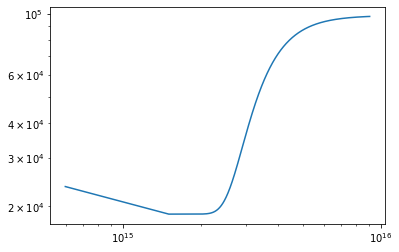

In [3]:
#### tsetup
agrd, bgrd, f = uw.build_grid(6e14,9e15,1000,25)

#f = copy.deepcopy(f1Myr)

Sigma0 = 133. 
f.Sigma_g = Sigma0*(agrd.R[2]/bgrd.R)**4.
f.Sigma_dust = np.outer(0.01 * f.Sigma_g,np.ones(f.Ndust))
f.sizes = np.logspace(-4.5,-1.75,f.Ndust)
f.Sc = np.ones(f.Ndust)
f.rho_int = np.zeros(f.Ndust) + 1.
f.GM = 6.67e-8*2e33
f.Omega_Kb = np.sqrt(f.GM/bgrd.R**3.)
f.Omega_Ka = np.sqrt(f.GM/agrd.R**3.)
f.alpha[:] = 1e-3
h = 1.0*np.sqrt(f.GM*bgrd.R[1])



# isothermal simulations
# f.cs = np.ones(np.size(f.cs))+1.e5

f.cs = np.ones(np.size(f.cs))+1.e5 # guess sound speed to calculate H
uw.get_mid_plane_values(f)
kappa = 15. 
use_dust_tau = False
temperature_update(bgrd,f,kappa,use_dust_tau)

plt.loglog(bgrd.R,f.cs)



f.uphi[:] = np.sqrt(f.GM/bgrd.R)

full_boundary_update(bgrd,f,agrd.R[agrd.ii],h,f.cs[0],Sigma0)

In [4]:
### Run a short time as a demonstration

time = 0.

use_alpha = True
nu_pl_index = 1.5

counter = 0

for i in range(50000):    
    
    dt = single_update(agrd,bgrd,f,h,Sigma0,kappa,use_alpha,nu_pl_index,use_dust_tau)
    
    if (i % 100000000 == 0):
        
        plt.figure()
        plt.loglog(bgrd.R,f.Sigma_g,'.')
        plt.loglog(bgrd.R,(agrd.R[agrd.ii]/bgrd.R)**(2.),'--')
        plt.loglog(bgrd.R,f.Sigma_dust[:,0])
        plt.savefig("fig%d.png" %counter)
        counter += 1
        plt.close()

        
    
    time += dt
    
    if (time > 0.09 * 1e6 * 31556926):
        break

print (time/31556926/1e3)

33.30404829484707


0.03330404829484707


(1e-06, 400.0)

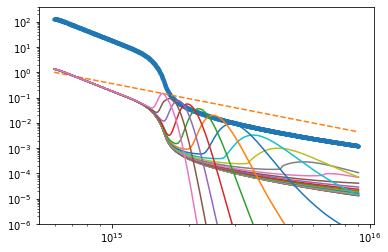

In [5]:
print (time/31556926/1e6)

plt.loglog(bgrd.R,f.Sigma_g,'.')
plt.loglog(bgrd.R,(agrd.R[agrd.ii]/bgrd.R)**(2.),'--')
#plt.loglog(bgrd.R,f.Sigma_dust[:,0])
#plt.loglog(bgrd.R,f.Sigma_dust[:,9])
plt.loglog(bgrd.R,f.Sigma_dust[:,:])
#plt.loglog(bgrd.R,f.Sigma_dust[:,29])

#print (f.Sigma_dust[:,-3])
#print(np.log10(f.sizes))

#fbig = np.load('big_dust.npy',allow_pickle=True).item()

#plt.loglog(bgrd.R,fbig.Sigma_dust[:,-1])


plt.ylim((1e-6,400.))

#f0p1Myr = copy.deepcopy(f)